# 2D maps of structure functions

This example will demonstrate how to create maps of various structure functions from a 2D velocity field. These maps describe how the structure functions vary with separation distance _and_ separation direction.

**General procedure:**

1. Set up plot environment & load/format the velocity data set
2. Calculate 2D maps of structure functions
3. Format output to create 2D (x-y) map of structure functions
4. Plot 2D maps of structure functions
5. Validate 2D-map structure functions against other modules

## Setup plot environment & load/format the velocity data set 
We will use `h5py` to load a `.jld2` file, the output from `GeophysicalFlows.jl`, a numerical ocean simulator written in Julia. The data consists of 2D (horizontal) fields simulated  a periodic domain. There are multiple snapshots of this data, corresponding to different times. We will 

In [1]:
import warnings

import h5py
import matplotlib_inline.backend_inline
import seaborn as sns

warnings.filterwarnings("ignore")  # Ignore warnings for the purpose of this tutorial

sns.set_style(style="white")
sns.set_context("talk")
matplotlib_inline.backend_inline.set_matplotlib_formats("png", dpi=200)


f = h5py.File("example_data/2layer_128.jld2", "r")
grid = f["grid"]
snapshots = f["snapshots"]

# Initialize the grid of x and y coordinates
x = grid["x"][()]
y = grid["y"][()]

# Isolate the top layer [0] of the final snapshot ['20050'] for the example calculations
u_data_for_example = snapshots["u"]["20050"][0]
v_data_for_example = snapshots["v"]["20050"][0]

Make a couple of quick plots to see the velocity fields.

## Calculate 2D maps of structure functions
By default this calculates the velocity advective structure function, but we also specify the traditional longitudinal structure functions (LLL and LL; the latter is calculated by default when LLL is calculated)

In [2]:
import fluidsf

sf_2D_maps = fluidsf.generate_sf_maps_2d(
    u_data_for_example, v_data_for_example, x, y, sf_type=["ASF_V", "LLL", "LL"]
)

## Format output to create 2D (x-y) map of structure functions

For computational efficiency, the package only calculates structure functions for separation vectors $\bf{r}$ where $\bf{r}\cdot\bf{\hat{x}} \ge 0$. The structure functions for the other half of the domain ($\bf{r}\cdot\bf{\hat{x}} \lt 0$) can be diagnosed from reflectional symmetry, noting that the structure functions here have the property $SF(\mathbf{r})=SF(-\mathbf{r})$. 

In [3]:
# Now we construct a 2D map of the advective structure function
# To do this, note that a separation vector with a positive x and y component
# is equivalent to a separation vector with negative x and y component,
# similarly the negative-y positive-x quadrant maps to positive-y negative-x

import matplotlib.pyplot as plt
import numpy as np

# First we construct these polar map arrays by appending these quadrants to the two
# already calculated

TwoD_map_x_separations = np.append(
    -np.flip(sf_2D_maps["x_separations"]), sf_2D_maps["x_separations"], axis=0
)
TwoD_map_y_separations = np.append(
    -np.flip(sf_2D_maps["y_separations"]), sf_2D_maps["y_separations"], axis=0
)
TwoD_map_advective_SF = np.append(
    np.flip(sf_2D_maps["SF_advection_velocity_xy"]),
    sf_2D_maps["SF_advection_velocity_xy"],
    axis=0,
)
TwoD_map_LL_SF = np.append(
    np.flip(sf_2D_maps["SF_LL_xy"]), sf_2D_maps["SF_LL_xy"], axis=0
)
TwoD_map_LLL_SF = np.append(
    np.flip(sf_2D_maps["SF_LLL_xy"]), sf_2D_maps["SF_LLL_xy"], axis=0
)

## Plot 2D maps of structure functions
We plot maps of the three velocity-based statistics that were diagnosed by the package: 

- Advective structure function, 
- Third-order longitudinal structure function, and 
- Second-order longitudinal structure function

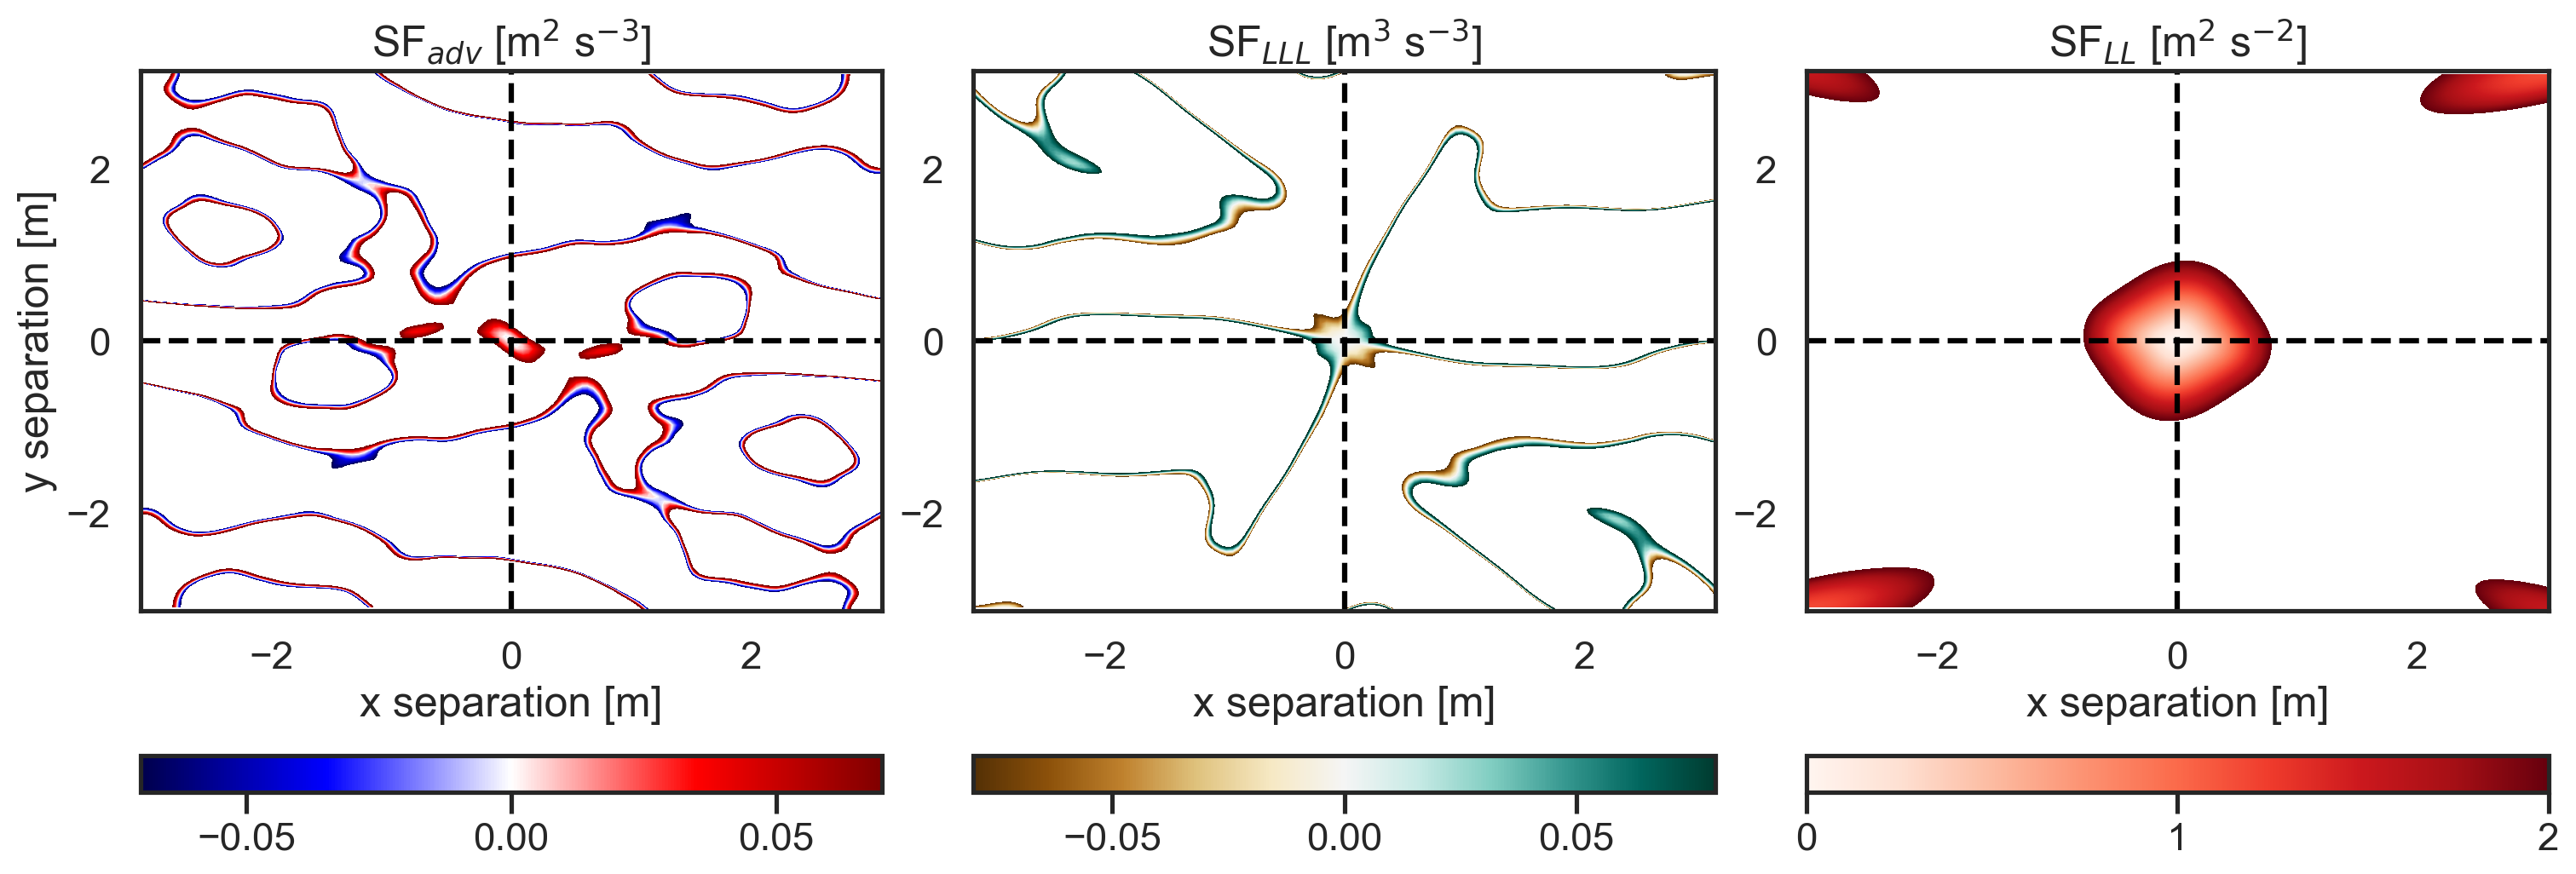

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), layout="constrained")

Advective = axs[0].contourf(
    TwoD_map_x_separations,
    TwoD_map_y_separations,
    TwoD_map_advective_SF,
    levels=np.linspace(-0.07, 0.07, 1001),
    cmap=plt.cm.seismic,
)
axs[0].set_xlabel("x separation [m]")
axs[0].set_ylabel("y separation [m]")
axs[0].set_title("SF$_{adv}$ [m$^2$ s$^{-3}$]")

cbar = fig.colorbar(Advective, ax=axs[0], location="bottom")
cbar.set_ticks([-0.05, 0, 0.05])
axs[0].axhline(0, color="black", linestyle="--")
axs[0].axvline(0, color="black", linestyle="--")

LLL = axs[1].contourf(
    TwoD_map_x_separations,
    TwoD_map_y_separations,
    TwoD_map_LLL_SF,
    levels=np.linspace(-0.08, 0.08, 1001),
    cmap=plt.cm.BrBG,
)
axs[1].set_xlabel("x separation [m]")
axs[1].set_title("SF$_{LLL}$ [m$^3$ s$^{-3}$]")

cbar = fig.colorbar(LLL, ax=axs[1], location="bottom")
cbar.set_ticks([-0.05, 0, 0.05])
axs[1].axhline(0, color="black", linestyle="--")
axs[1].axvline(0, color="black", linestyle="--")

LL = axs[2].contourf(
    TwoD_map_x_separations,
    TwoD_map_y_separations,
    TwoD_map_LL_SF,
    levels=np.linspace(0, 2, 1001),
    cmap=plt.cm.Reds,
)
axs[2].set_xlabel("x separation [m]")
axs[2].set_title("SF$_{LL}$ [m$^2$ s$^{-2}$]")

cbar = fig.colorbar(LL, ax=axs[2], location="bottom")
cbar.set_ticks([0, 1, 2])
axs[2].axhline(0, color="black", linestyle="--")
axs[2].axvline(0, color="black", linestyle="--");

## Plot some other useful output: separation distance and separation angle
The 2D map modules also output separation distance and angle. These could be useful for users, for example when binning or performing analyses. We visualize them here
to demonstrate how to access and use these arrays

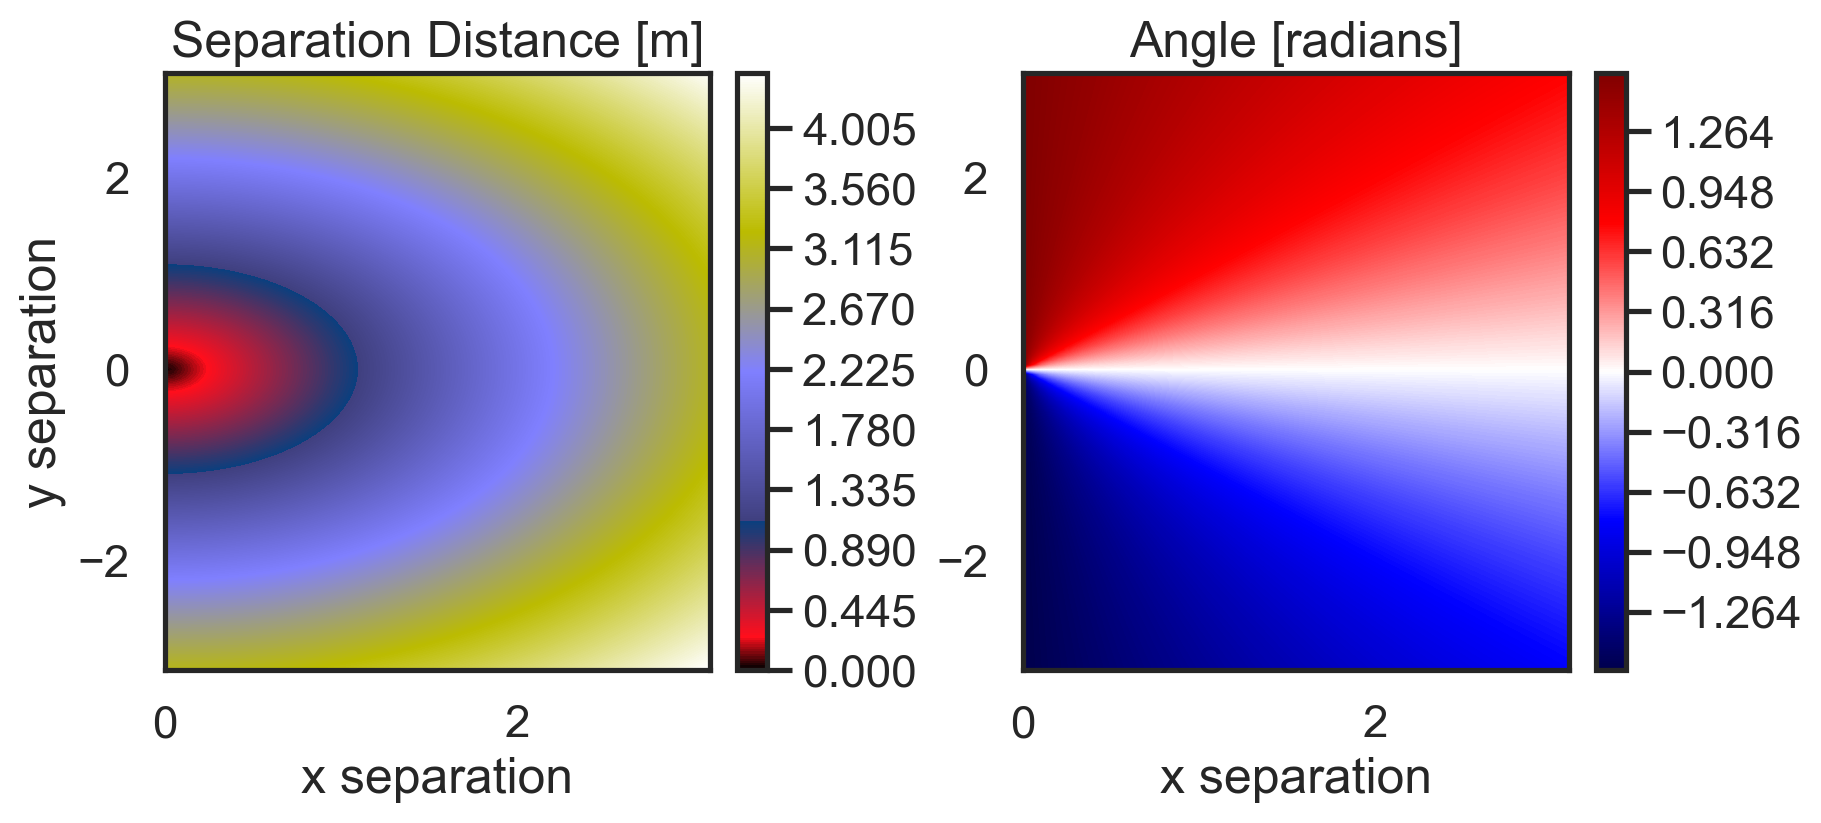

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4), layout="constrained")

distances = axs[0].contourf(
    sf_2D_maps["x_separations"],
    sf_2D_maps["y_separations"],
    sf_2D_maps["separation_distances"],
    1000,
    cmap=plt.cm.gist_stern,
)

axs[0].set_title("Separation Distance [m]")
axs[0].set_xlabel("x separation")
axs[0].set_ylabel("y separation")

# Make a colorbar for the ContourSet returned by the contourf call.
cbar = fig.colorbar(distances, ax=axs[0])

angles = axs[1].contourf(
    sf_2D_maps["x_separations"],
    sf_2D_maps["y_separations"],
    sf_2D_maps["separation_angles"],
    1000,
    cmap=plt.cm.seismic,
)

axs[1].set_title("Angle [radians]")
axs[1].set_xlabel("x separation")

# Make a colorbar for the ContourSet returned by the contourf call.
cbar = fig.colorbar(angles, ax=axs[1]);

## Validate 2D-map structure functions against other modules
First, let us check that the polar code calculates the same zonal (purely x-separated) and meridional (purely y-separated) advective structure functions as the core 1D calculation modules. Then we will repeat for the third- and second-order longitudinal structure functions. We will start by calculating the zonal and meridional structure functions directly.

In [6]:
sf_zonal_meridional = fluidsf.generate_structure_functions(
    u_data_for_example, v_data_for_example, x, y, sf_type=["ASF_V", "LLL", "LL"]
)

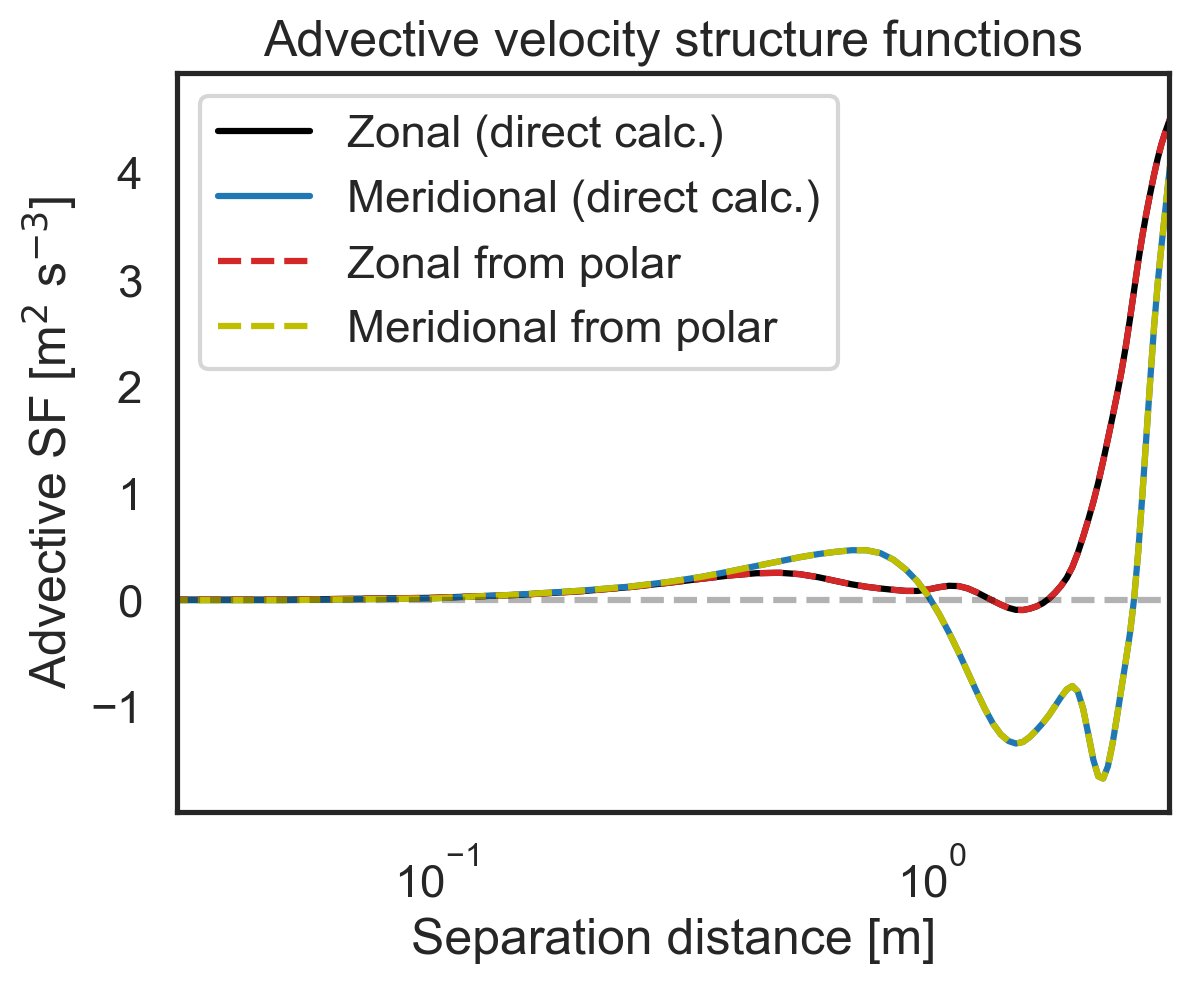

In [7]:
# Contrasting advective structure functions

import matplotlib.pyplot as plt

fig, (ax1) = plt.subplots()

ax1.semilogx(
    sf_zonal_meridional["x-diffs"],
    sf_zonal_meridional["SF_advection_velocity_x"],
    label=r"Zonal (direct calc.)",
    color="k",
)
ax1.semilogx(
    sf_zonal_meridional["y-diffs"],
    sf_zonal_meridional["SF_advection_velocity_y"],
    label=r"Meridional (direct calc.)",
    color="tab:blue",
)
ax1.semilogx(
    sf_zonal_meridional["y-diffs"],
    sf_2D_maps["SF_advection_velocity_xy"][:, 64],
    label=r"Zonal from polar",
    color="tab:red",
    linestyle="dashed",
)
ax1.semilogx(
    sf_zonal_meridional["y-diffs"],
    sf_2D_maps["SF_advection_velocity_xy"][0, 64:],
    label=r"Meridional from polar",
    color="y",
    linestyle="dashed",
)

ax1.set_ylabel(r"Advective SF [m$^2$ s$^{-3}$]")
ax1.set_xlabel(r"Separation distance [m]")
ax1.set_xlim(3e-2, 3e0)
ax1.legend()
plt.hlines(0, 3e-2, 3e0, color="k", linestyle="dashed", alpha=0.3)
plt.title("Advective velocity structure functions");

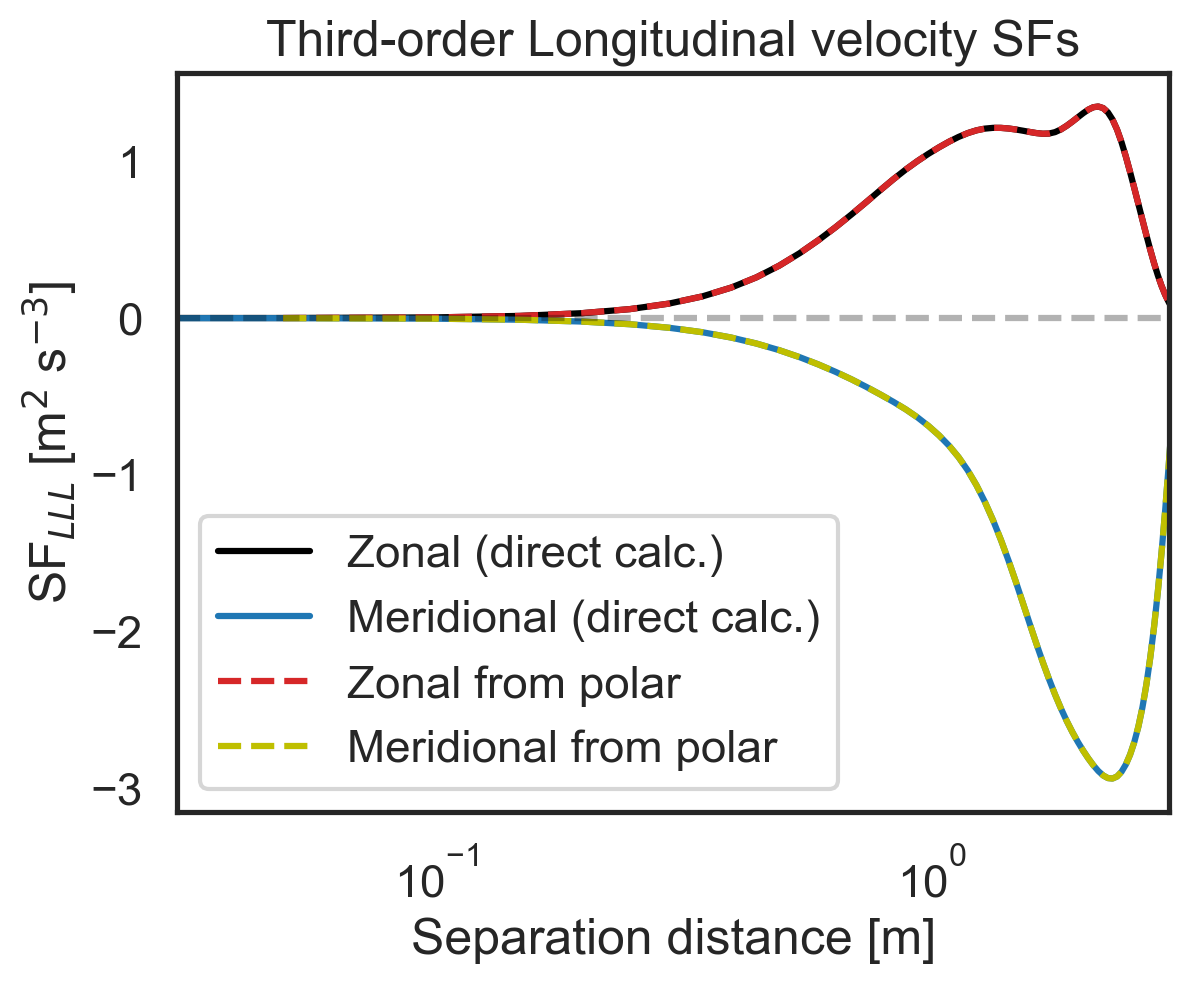

In [8]:
# Then repeat check for third-order longitudinal SF

import matplotlib.pyplot as plt

fig, (ax1) = plt.subplots()

ax1.semilogx(
    sf_zonal_meridional["x-diffs"],
    sf_zonal_meridional["SF_LLL_x"],
    label=r"Zonal (direct calc.)",
    color="k",
)
ax1.semilogx(
    sf_zonal_meridional["y-diffs"],
    sf_zonal_meridional["SF_LLL_y"],
    label=r"Meridional (direct calc.)",
    color="tab:blue",
)
ax1.semilogx(
    sf_zonal_meridional["y-diffs"],
    sf_2D_maps["SF_LLL_xy"][:, 64],
    label=r"Zonal from polar",
    color="tab:red",
    linestyle="dashed",
)
ax1.semilogx(
    sf_zonal_meridional["y-diffs"],
    sf_2D_maps["SF_LLL_xy"][0, 64:],
    label=r"Meridional from polar",
    color="y",
    linestyle="dashed",
)

ax1.set_ylabel(r"SF$_{LLL}$ [m$^2$ s$^{-3}$]")
ax1.set_xlabel(r"Separation distance [m]")
ax1.set_xlim(3e-2, 3e0)
ax1.legend()
plt.hlines(0, 3e-2, 3e0, color="k", linestyle="dashed", alpha=0.3)
plt.title("Third-order Longitudinal velocity SFs");

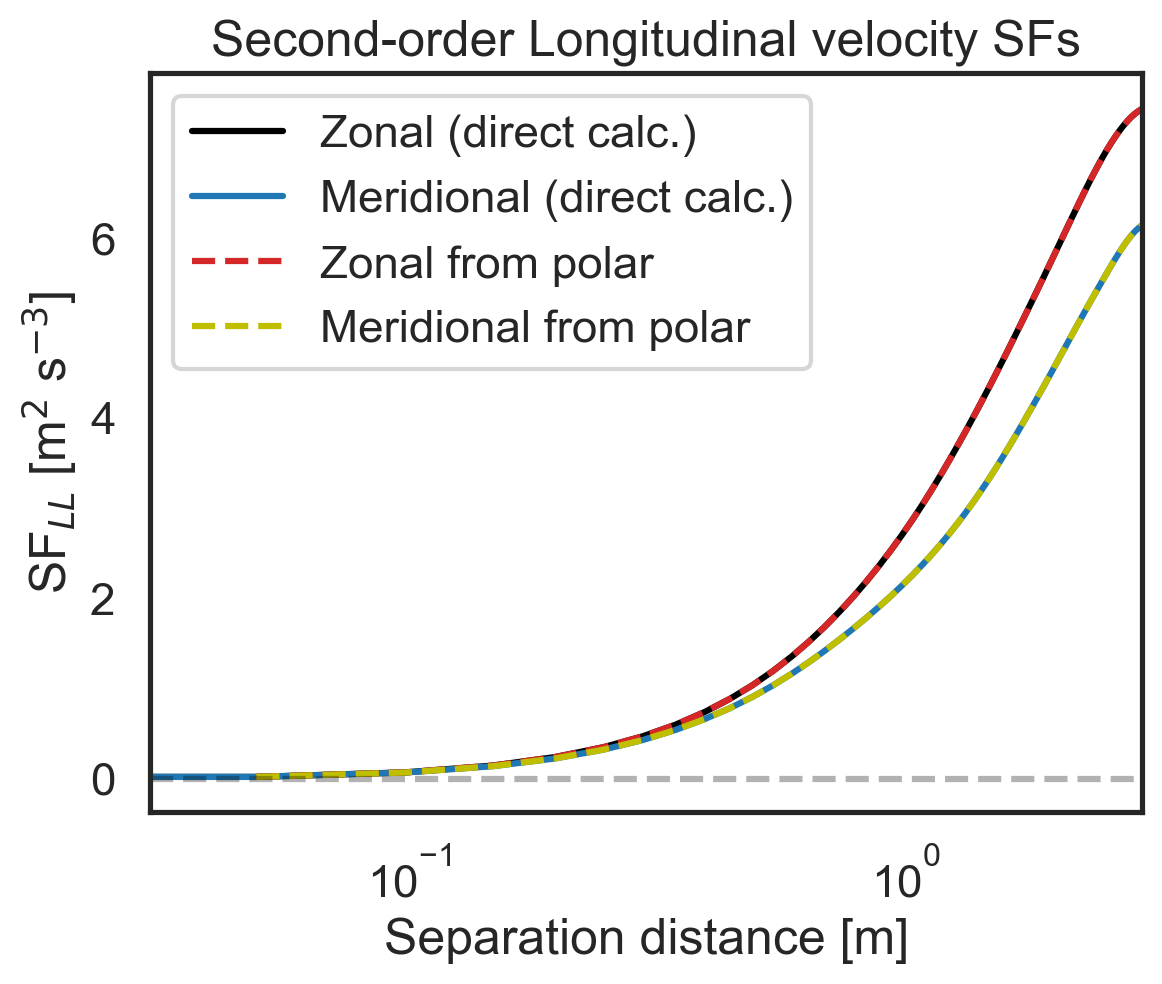

In [9]:
# Then repeat check for second-order longitudinal SF

import matplotlib.pyplot as plt

fig, (ax1) = plt.subplots()

ax1.semilogx(
    sf_zonal_meridional["x-diffs"],
    sf_zonal_meridional["SF_LL_x"],
    label=r"Zonal (direct calc.)",
    color="k",
)
ax1.semilogx(
    sf_zonal_meridional["y-diffs"],
    sf_zonal_meridional["SF_LL_y"],
    label=r"Meridional (direct calc.)",
    color="tab:blue",
)
ax1.semilogx(
    sf_zonal_meridional["y-diffs"],
    sf_2D_maps["SF_LL_xy"][:, 64],
    label=r"Zonal from polar",
    color="tab:red",
    linestyle="dashed",
)
ax1.semilogx(
    sf_zonal_meridional["y-diffs"],
    sf_2D_maps["SF_LL_xy"][0, 64:],
    label=r"Meridional from polar",
    color="y",
    linestyle="dashed",
)

ax1.set_ylabel(r"SF$_{LL}$ [m$^2$ s$^{-3}$]")
ax1.set_xlabel(r"Separation distance [m]")
ax1.set_xlim(3e-2, 3e0)
ax1.legend()
plt.hlines(0, 3e-2, 3e0, color="k", linestyle="dashed", alpha=0.3)
plt.title("Second-order Longitudinal velocity SFs");